In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.nn import depth_to_space
from tensorflow.nn import depth_to_space
from PIL import Image

In [4]:
IMG_SHAPE = 256
LATENT_DIM = 64
NUM_CHANNELS = 3

In [7]:
def image_resizer(hr_path,lr_path, HR_SHAPE, LR_SHAPE):
    hr_image_store = {}
    lr_image_store = {}
    
    hr_image_dir = glob.glob(hr_path)
    lr_image_dir = glob.glob(lr_path)
    
    for i,j in zip(hr_image_dir,lr_image_dir):
        hr_filename = i.split('/')[-1].split('.')[0]
        lr_filename = j.split('/')[-1].split('.')[0]
        
        hr_image = Image.open(i)
        lr_image = Image.open(j)
        
        #hr_image = tf.image.decode_jpeg(hr_image)
        hr_image = hr_image.resize((HR_SHAPE, HR_SHAPE))
        
        #lr_image = tf.image.decode_jpeg(lr_image)
        lr_image = lr_image.resize((LR_SHAPE, LR_SHAPE))
        
        hr_image_store[hr_filename] = np.array(hr_image)
        lr_image_store[lr_filename] = np.array(lr_image)
        
    return hr_image_store,lr_image_store

In [9]:
hr_path = 'D:/Lectures/DLS/Project/Data/HR/*'
lr_path = 'D:/Lectures/DLS/Project/Data/LR/*'

a,b = image_resizer(hr_path,lr_path, 256, 256)

hr_image_store,lr_image_store = list(a.values()), list(b.values())

hr_image_store = np.stack(hr_image_store)
lr_image_store = np.stack(lr_image_store)

In [11]:
IMG_SHAPE=256

In [25]:
def PSNR(super_resolution, high_resolution):
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

def SSIM(super_resolution, high_resolution):
    ssim_value = tf.image.ssim(super_resolution, high_resolution, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)[1]
    return ssim_value

def mse_loss(real, pred):
    mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    loss = mse(real, pred)
    loss = tf.reduce_mean(loss)
    return loss

In [17]:
input_img = tf.keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3)) #(accepts only 256, 256, 3)

ll = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1.0/255, offset=0.0)(input_img)

l00 = tf.keras.layers.Conv2D(32, (6, 6), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(ll)
l01 = tf.keras.layers.Conv2D(32, (6, 6), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l00)
l02 = tf.keras.layers.MaxPool2D(padding='same')(l01)


l1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l02)
l2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
l3 = tf.keras.layers.MaxPool2D(padding='same')(l2)

l4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
l5 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
l6 = tf.keras.layers.MaxPool2D(padding='same')(l5)

l7 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

l8 = tf.keras.layers.Conv2DTranspose(64, 3, 
                                     padding='same', 
                                     activation='relu',
                                     strides=(2,2))(l7)
l9 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
l10 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)

l11 = tf.keras.layers.add([l10, l5])

l12 = tf.keras.layers.Conv2DTranspose(64, 3, 
                                     padding='same', 
                                     activation='relu',
                                     strides=(2,2))(l11)
l13 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
l14 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l13)

l15 = tf.keras.layers.add([l14, l2])

decoded_image = tf.keras.layers.Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

autoencoder = tf.keras.models.Model(inputs=(input_img), outputs=decoded_image)

autoencoder.compile(optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.01), #optimizer='adam', #optimizer='adadelta',
                    loss='mean_absolute_error', 
                    metrics = [tf.keras.metrics.RootMeanSquaredError(name = 'rmse'), PSNR, SSIM])

In [18]:
autoencoder.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 32) 3488        rescaling_1[0][0]                
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 32) 36896       conv2d_24[0][0]                  
_______________________________________________________________________________________

In [27]:
csv_logger = tf.keras.callbacks.CSVLogger('AEC_training.log')

history = autoencoder.fit(lr_image_store,
                          validation_data = hr_image_store,
                          epochs = 300, callbacks=[csv_logger])

Epoch 1/300
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 

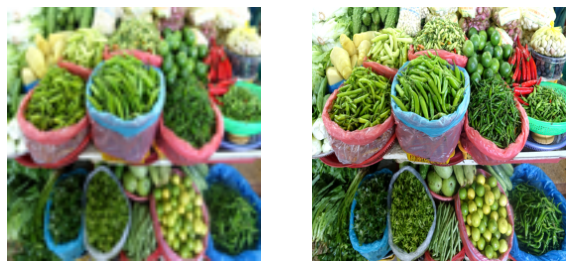

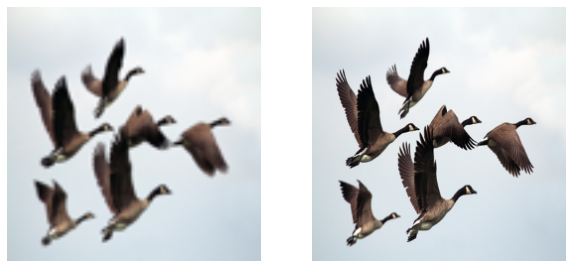

In [55]:
preds = autoencoder.predict(val_dataset_lr.take(2))

for img_input, img_output in zip(val_dataset_lr.take(2),preds):
    fig, ax = plt.subplots(1,2, figsize = (10,10))
    ax[0].imshow(img_input.numpy()[7])
    ax[0].axis("off")
    ax[1].imshow(img_output.numpy()[7])
    ax[1].axis("off")